# Unsupervised anomaly detection (fraud) algorithm

This notebook has good example algorithms to do a forensic-type analysis, looking for anomalies in a dataset. We first do some data cleaning (exclusions, imputation, don't remove outliers - that's what we're looking for), then build variables that are designed to look for the kinds of anomalies we are interested in, in this case, unusual property valuations.

After we build the variables we know we have lots of correlations and too high dimensionality so we need to remove correlations and reduce dimensionality. Since we don't have a dependent variable the easiest useful thing to do is PCA. We z scale (always z scale before a PCA), do PCA, keep the top few PCs, then z scale again in order to make each retained PC equally important (optional step; only do this if you keep just a few PCs.).

We use two different anomaly detection (fraud) algorithms. The first just looks for outliers in the final scaled PC space using a Minkowski distance from the origin. The second method makes a simple autoencoder and the fraud score is then the reproduction error. It's important to note that each/either of these two methods would be a fine fraud score by itself.

Since we have two score and we don't really know which one is better we just average the two scores. To do this we replace the score with its rank order and then average the rank-ordered scores for our final score.

Finally we sort all the records by this final score and explore the top n records. To help the investigation we show which of the variables are driving these top scoring records with a heat map of the variable zscores, which can point the investigators to what's making the high score for these top scoring records.

This problem is an invented problem to demonstrate the process of building unsupervised fraud models. The data set is real and the invented problem is realistic. What's lacking the most is the ability to interact with domain experts in order to do proper exclusions and design good/appropriate variables.

The data can be found here: https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-Data/rgy2-tti8

In [1]:
from datetime import datetime
start_time = datetime.now()

from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

CPU times: total: 1.69 s
Wall time: 2.61 s


(1070994, 32)

In [3]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [4]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Remove some properties that we aren't interested in

In [5]:
numrecords_orig = len(data)
numrecords = numrecords_orig
numrecords

1070994

In [6]:
#remove the records with easement type as goverment 
data = data[data["EASEMENT"] != "U"].reset_index(drop=True)
numremoved = numrecords - len(data)
print('# records removed:', numremoved)

# records removed: 1


In [7]:
# create some words for the owner name that might be goverment or a cemetery
gov_list = ['DEPT ', 'DEPARTMENT', 'UNITED STATES','GOVERNMENT',' GOVT ', 'CEMETERY']

# owner = list(set(data['OWNER'].to_list()))
# owner.pop(0) #remove the nan

owner1 = list(set(data['OWNER'].to_list()))
owner = [item for item in owner1 if str(item) != 'nan'] # remove any nan's

remove_list = []
print("Total owner number before removing is ", len(owner))

for i in owner:
   for g in gov_list:
    if g in i and 'STORES' not in i:
        remove_list.append(i)

Total owner number before removing is  863347


In [8]:
remove_list # check all the name here and edit if it is not a goverment name 

['SILVER MNT CEMETERY',
 'DEPT HOUSING PRESERVA',
 'UNITED STATES A HUD',
 'NYC DEPT WATER RES',
 'LUTHERAN CEMETERY',
 'NYC DEPT HIGHWAYS',
 'US GOVERNMENT',
 'GOVERNMENT OF ISRAEL',
 'DEPT PUBLIC WORKS',
 'DEPT OF PUBLIC WORKS',
 'GOVERNMENT/FEDERAL RE',
 'NYC DEPARTMENT OF HOM',
 'NYC DEPT REAL ESTATE',
 'U S GOVT LAND & BLDGS',
 'GOVERNMENT OF THE REP',
 'DEPT OF HIGHWAYS NYC',
 'EVERGREEN CEMETERY',
 'UNITED STATES POSTAL',
 'NYS DEPT TRANSPORTATI',
 'NYC DEPT OF R E',
 'THE UNITED STATES POS',
 'UNITED STATES OF AMER',
 'UNITED STATES AMERICA',
 "SAINT JOHN'S CEMETERY",
 'THE GOVERNMENT OF COT',
 'MACHPELAH CEMETERY',
 'GOVERNMENT KINGDOM LE',
 'GOVERNMENT OF JAPAN',
 'UNITED STATES A VA',
 'U S GOVT POST OFFIC',
 'BARON HIRSCH CEMETERY',
 'NYC-DEPT OF HIGHWAYS',
 'THE GOVERNMENT OF THE',
 'STATE OF NY DEPT P W',
 'DEPARTMENT OF BUSINES',
 'US DEPT OF HUD-MF/REO',
 'DEPT OF HIGHWAYS',
 'FLUSHING CEMETERY ASS',
 'DEPARTMENT OF HPD',
 'NYC DEPT HGHWAYS',
 'GOVERNMENT OF THE UNI',
 

In [9]:
# Look at the most frequent owners. This might show some other properties we aren't interested in.
remove_list2 = data['OWNER'].value_counts().head(20).index.tolist()
remove_list2

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [10]:
# add some others to also be removed
remove_list2.append('THE CITY OF NEW YORK')
remove_list2.append('NYS URBAN DEVELOPMENT')
remove_list2.append('CULTURAL AFFAIRS')
remove_list2.append('NY STATE PUBLIC WORKS')
remove_list2.append("NYC DEP'T OF HIGHWAYS")
remove_list2.append('CITY WIDE ADMINISTRAT')
remove_list2.append('NEW YORK CITY')
remove_list2.append('THE PORT OFNY & NJ')
remove_list2.append('NEW YORK STATE DEPART')
remove_list2.append('CITY AND NON-CITY OWN')
remove_list2.append('SANITATION')
remove_list2.append('NYS DOT')
remove_list2.append('NEW YORK CITY TRANSIT')
remove_list2.append('PORT AUTHORITY OF NY')
remove_list2.append('NEW YORK STATE OWNED')
remove_list2.append('NYC PARK DEPT')
remove_list2.append('PORT OF NEW YORK AUTH')
remove_list2.append('NYC PARK DEPT')
remove_list2.append('LIRR')
remove_list2.append('NY STATE PUBLIC SERV')
remove_list2.append('STATE OF NEW YORK')
remove_list2.append('NYC HIGHWAY DEPT')

In [11]:
for i in remove_list2:
    if i not in remove_list:
        remove_list.append(i)
    else:
        print(i)

DEPT OF ENVIRONMENTAL
DEPARTMENT OF BUSINES
DEPT OF TRANSPORTATIO
NYC PARK DEPT


In [12]:
# rremove some of the removes...
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.remove('MH RESIDENTIAL 1, LLC')

In [13]:
len(remove_list)

263

In [14]:
numrecords = len(data)
removed = data[data['OWNER'].isin(remove_list)].reset_index(drop=True)
data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)
numremoved = numrecords - len(data)
print('# records removed:', numremoved)

# records removed: 26500


In [15]:
removed.shape

(26500, 32)

<Axes: ylabel='OWNER'>

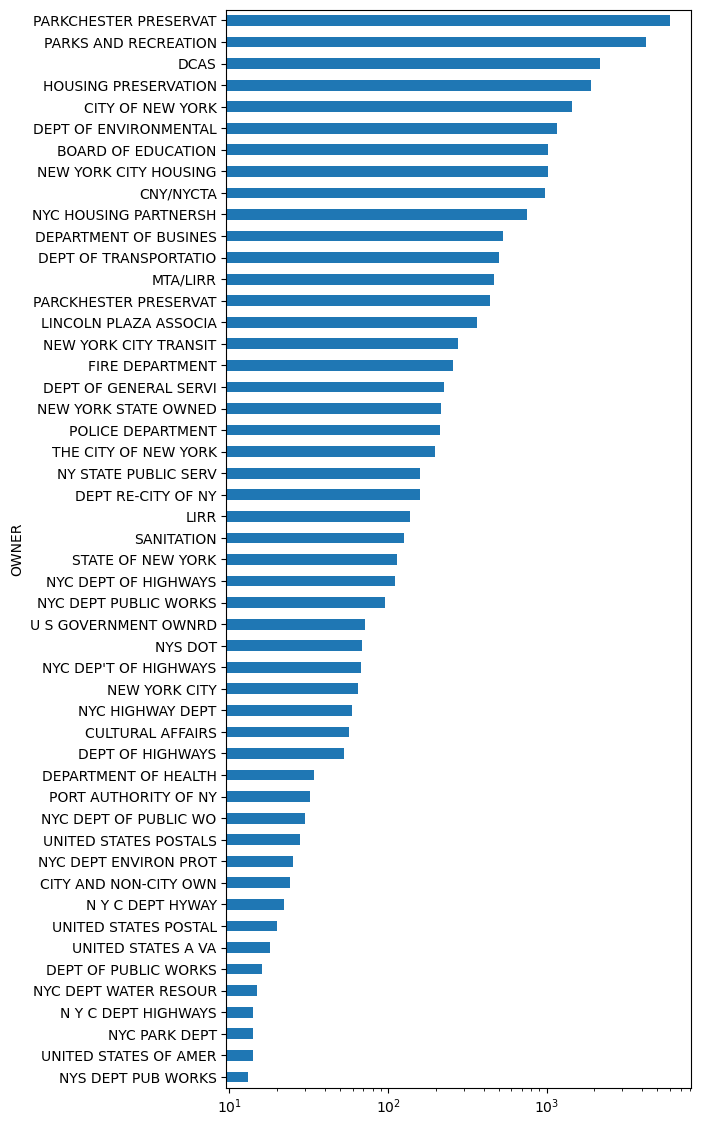

In [16]:
# any on this list that we shouldn't remove?
# plt.rcParams.update({'figure.figsize':(6,14)})
plt.figure(figsize=(6,14))
plt.xscale('log')
removed['OWNER'].value_counts().head(50).sort_values().plot(kind='barh')

In [17]:
data.shape

(1044493, 32)

In [18]:
# this is how many records we removed
numrecords_orig - len(data)

26501

In [19]:
data.head(10)

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,636093.0,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,919276.0,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,967500.0,5483912.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,163174.0,525692.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,373783.0,1204211.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
5,14,1000041006,1,4,1006,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,353383.0,1138493.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
6,15,1000041007,1,4,1007,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1246572.0,4016063.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
7,16,1000041008,1,4,1008,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
8,17,1000041009,1,4,1009,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
9,18,1000041010,1,4,1010,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR


## Fill in missing ZIP

In [20]:
# How many zips are missing? Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
num_missing_zips_orig = len(missing_zips)
num_missing_zips_orig

20431

In [21]:
sum(data['BORO'].isna())

0

In [22]:
sum(data['STADDR'].isna())

364

In [23]:
# concatenate the 'staddr' and 'boro' columns into a new 'staddr_boro' column 
data['staddr_boro'] = data[data['STADDR'].notnull()]['STADDR'] + '_' + data[data['BORO'].notnull()]['BORO'].astype(str)
data['staddr_boro']

0              1 WATER STREET_1
1              1 WATER STREET_1
2              1 WATER STREET_1
3              1 WATER STREET_1
4              1 WATER STREET_1
                   ...         
1044488    142 BENTLEY STREET_5
1044489    146 BENTLEY STREET_5
1044490    150 BENTLEY STREET_5
1044491    156 BENTLEY STREET_5
1044492    162 BENTLEY STREET_5
Name: staddr_boro, Length: 1044493, dtype: object

In [24]:
staddr_boro_zip = {}
for index, staddrboro in data['staddr_boro'].items():
    if staddrboro not in staddr_boro_zip :
        staddr_boro_zip [staddrboro] = data.loc[index, 'ZIP']
        
        
# fill in by mapping with street addrees boroughs
data['ZIP'] = data['ZIP'].fillna(data['staddr_boro'].map(staddr_boro_zip))

In [25]:
# how many mnissing zips did we fill in with this last step?
num_filled_in = num_missing_zips_orig - len(np.where(pd.isnull(data['ZIP']))[0])
num_filled_in

2832

In [26]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

17599

In [27]:
%%time
# Assume the data is already sorted by zip. If a zip is missing, 
# and the before and after zips are the same, fill in the zip with that value
# There should be a more efficient way to calculate this rather than this slow loop...
for i in range(len(missing_zips)):
    if(data.loc[missing_zips[i]+1,'ZIP'] == data.loc[missing_zips[i]-1,'ZIP']):
        data.loc[missing_zips[i],'ZIP'] = data.loc[missing_zips[i]-1,'ZIP']

CPU times: total: 875 ms
Wall time: 1.24 s


In [28]:
# how many mnissing zips did we fill in with this last step?
num_filled_in = len(missing_zips) - len(np.where(pd.isnull(data['ZIP']))[0])
num_filled_in

9491

In [29]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

8108

In [30]:
%%time
# For the remaining missing zips, just fill in with the previous record's zip.
# another slow loop that should be improved...
for i in range(len(missing_zips)):
    data.loc[missing_zips[i],'ZIP'] = data.loc[missing_zips[i]-1,'ZIP']

CPU times: total: 438 ms
Wall time: 737 ms


In [31]:
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

0

In [32]:
data = data.drop('staddr_boro', axis=1)

### FULLVAL, AVLAND, AVTOT

#### FULLVAL

In [33]:
len(data[data['FULLVAL']==0])

10025

In [34]:
data['FULLVAL'].isnull().sum()

0

In [35]:
data['FULLVAL'].replace(0, np.nan, inplace=True)
data['FULLVAL'].isnull().sum()

C:\Users\josh9\AppData\Local\Temp\ipykernel_22844\3840300546.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['FULLVAL'].replace(0, np.nan, inplace=True)


10025

In [36]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

7307

In [37]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS','BORO'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

386

In [38]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

0

#### AVLAND

In [39]:
len(data[data['AVLAND']==0])

10027

In [40]:
data['AVLAND'].isnull().sum()

0

In [41]:
data['AVLAND'].replace(0, np.nan, inplace=True)
data['AVLAND'].isnull().sum()

C:\Users\josh9\AppData\Local\Temp\ipykernel_22844\116382313.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['AVLAND'].replace(0, np.nan, inplace=True)


10027

In [42]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

7307

In [43]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS','BORO'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

386

In [44]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

0

#### AVTOT

In [45]:
len(data[data['AVTOT']==0])

10025

In [46]:
data['AVTOT'].isnull().sum()

0

In [47]:
data['AVTOT'].replace(0, np.nan, inplace=True)
data['AVTOT'].isnull().sum()

C:\Users\josh9\AppData\Local\Temp\ipykernel_22844\3655551349.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['AVTOT'].replace(0, np.nan, inplace=True)


10025

In [48]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

7307

In [49]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS','BORO'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

386

In [50]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

0

In [51]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,R5,R5,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,0,0,0,0,0


## Fill in the missing STORIES

In [52]:
data['STORIES'].isnull().sum()

42030

In [53]:
modes = data.groupby(['BORO', 'BLDGCL'])['STORIES'] \
         .transform(lambda x: x.mode(dropna=False).iloc[0])
data['STORIES'] = data['STORIES'].fillna(modes)

In [54]:
data['STORIES'].isnull().sum()

37922

In [55]:
data["STORIES"] = data.\
                        groupby(['TAXCLASS'])['STORIES'].transform(lambda x: x.fillna(x.mean()))

In [56]:
data['STORIES'].isnull().sum()

0

In [57]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,R5,R5,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,0,0,0,0,0


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [58]:
# Because these 4 fields do not have NAs, we just need to replace 0s. 
# We think zero and 1 are invalid values for these fields, so replace them with NA.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
# Not sure which values to treat as missing. here are some choices.
data.loc[data['LTFRONT']==0,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==0,'LTDEPTH']=np.nan
data.loc[data['BLDFRONT']==0,'BLDFRONT']=np.nan
data.loc[data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
# data.loc[data['LTFRONT']==1,'LTFRONT']=np.nan
# data.loc[data['LTDEPTH']==1,'LTDEPTH']=np.nan
# data.loc[data['BLDFRONT']==1,'BLDFRONT']=np.nan
# data.loc[data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

In [59]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,NaN,NaN,636093.0,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,NaN,NaN,919276.0,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,NaN,NaN,967500.0,5483912.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,NaN,NaN,163174.0,525692.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,NaN,NaN,373783.0,1204211.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR


#### LTFRONT

In [60]:
data['LTFRONT'].isnull().sum()

160565

In [61]:
data["LTFRONT"] = data.\
                        groupby(['TAXCLASS','BORO'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))
data[data['LTFRONT'].isnull()]

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
126002,127752,1018259034,1,1825,9034,NaN,NaN,V0,1B,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
126003,127753,1018259036,1,1825,9036,NaN,NaN,V0,1B,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


In [62]:
data["LTFRONT"] = data.\
                        groupby(['TAXCLASS'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))
data['LTFRONT'].isnull().sum()

0

#### LTDEPTH

In [63]:
data['LTDEPTH'].isnull().sum()

161656

In [64]:
data["LTDEPTH"] = data.\
                        groupby(['TAXCLASS','BORO'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))
data[data['LTDEPTH'].isnull()]

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
126002,127752,1018259034,1,1825,9034,NaN,NaN,V0,1B,45.157933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
126003,127753,1018259036,1,1825,9036,NaN,NaN,V0,1B,45.157933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


In [65]:
data["LTDEPTH"] = data.\
                        groupby(['TAXCLASS'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['LTDEPTH'].isnull().sum()

0

#### BLDFRONT

In [66]:
data['BLDFRONT'].isnull().sum()

206851

In [67]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

18672

In [68]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS','BORO'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

15718

In [69]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

#### BLDEPTH

In [70]:
data['BLDDEPTH'].isnull().sum()

206886

In [71]:
206886 - 15804

191082

In [72]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

15804

In [73]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS','BORO'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

12830

In [74]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [75]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [76]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [77]:
data.count()

RECORD      1044493
BBLE        1044493
BORO        1044493
BLOCK       1044493
LOT         1044493
EASEMENT       1976
OWNER       1012749
BLDGCL      1044493
TAXCLASS    1044493
LTFRONT     1044493
LTDEPTH     1044493
EXT          353646
STORIES     1044493
FULLVAL     1044493
AVLAND      1044493
AVTOT       1044493
EXLAND      1044493
EXTOT       1044493
EXCD1        623529
STADDR      1044129
ZIP         1044493
EXMPTCL        9296
BLDFRONT    1044493
BLDDEPTH    1044493
AVLAND2      266066
AVTOT2       266072
EXLAND2       80845
EXTOT2       117834
EXCD2         92904
PERIOD      1044493
YEAR        1044493
VALTYPE     1044493
zip3        1044493
dtype: int64

In [78]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


In [79]:
len(cols)

33

### Now build variables that try to find properties that are unusual in ways we're interested in

In [80]:
# epsilon is an arbitrary small number to make sure we don't divide by zero
epsilon = .0001
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH'] + epsilon
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH'] + epsilon
data['bldvol'] = data['bldsize'] * data['STORIES'] + epsilon

In [81]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [82]:
data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,...,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,5.368069e+05,3.220281e+00,4.756777e+03,3.509013e+02,5.038952e+01,1.073730e+02,4.969850e+00,8.166002e+05,6.654802e+04,1.999379e+05,...,6.142891e+04,2.131696e+02,5.692701e+02,2.588469e+02,1.015699e+01,2.874586e+01,1.221970e+01,2.563845e+01,5.754061e+01,2.180193e+01
std,3.080025e+05,1.199074e+00,3.677416e+03,8.267095e+02,5.998346e+01,5.153903e+01,8.225039e+00,6.399805e+06,2.012308e+06,5.392440e+06,...,2.325183e+06,1.075806e+03,7.548754e+03,3.548384e+03,1.027257e+02,2.274915e+03,1.311404e+03,1.853214e+02,2.961310e+03,1.361625e+03
min,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,...,1.000200e+00,3.623988e-04,8.696730e-04,6.269316e-05,8.333333e-06,9.663034e-05,7.433103e-06,8.333333e-06,2.000000e-04,3.716551e-05
25%,2.729100e+05,3.000000e+00,1.542000e+03,2.300000e+01,2.100000e+01,1.000000e+02,2.000000e+00,3.181550e+05,9.679000e+03,1.892600e+04,...,1.408000e+03,7.587719e+01,2.066326e+02,8.020833e+01,2.376800e+00,5.982863e+00,2.171224e+00,5.388272e+00,1.737000e+01,7.243635e+00
50%,5.387720e+05,3.000000e+00,4.078000e+03,4.900000e+01,3.000000e+01,1.000000e+02,2.000000e+00,4.540000e+05,1.387800e+04,2.579100e+04,...,2.210000e+03,1.534691e+02,5.000000e+02,2.391975e+02,4.592648e+00,1.504231e+01,7.181499e+00,8.628333e+00,2.700384e+01,1.272714e+01
75%,8.022750e+05,4.000000e+00,6.920000e+03,1.400000e+02,6.000000e+01,1.120000e+02,4.000000e+00,6.240000e+05,1.998000e+04,4.724400e+04,...,7.020001e+03,2.430107e+02,6.853800e+02,3.364660e+02,7.219375e+00,2.035614e+01,1.006684e+01,1.354054e+01,3.602777e+01,1.760000e+01
max,1.070994e+06,5.000000e+00,1.635000e+04,9.450000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,2.205711e+09,8.359164e+05,3.711629e+06,2.929414e+06,6.364894e+04,1.549375e+06,1.318236e+06,7.055341e+04,1.670233e+06,1.318236e+06


I want outliers in these 9 variables, either very high or very low. Very high is easy to find but very low might be close to
zero and probably not many standard deviations below the average. A simple way to look for outliers that are very low is to also include 1/over these variables, which will be very large outliers when the variables are very low.
First I scale them all to have reasonable average.

In [83]:
vars9 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9']
for vars in vars9:
    data[vars] = data[vars]/data[vars].median()
    
data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,...,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,5.368069e+05,3.220281e+00,4.756777e+03,3.509013e+02,5.038952e+01,1.073730e+02,4.969850e+00,8.166002e+05,6.654802e+04,1.999379e+05,...,6.142891e+04,1.389007e+00,1.138540e+00,1.082147e+00,2.211576e+00,1.911001e+00,1.701553e+00,2.971426e+00,2.130830e+00,1.713027e+00
std,3.080025e+05,1.199074e+00,3.677416e+03,8.267095e+02,5.998346e+01,5.153903e+01,8.225039e+00,6.399805e+06,2.012308e+06,5.392440e+06,...,2.325183e+06,7.009922e+00,1.509751e+01,1.483453e+01,2.236742e+01,1.512344e+02,1.826087e+02,2.147824e+01,1.096625e+02,1.069859e+02
min,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,...,1.000200e+00,2.361380e-06,1.739346e-06,2.620979e-07,1.814494e-06,6.423904e-06,1.035035e-06,9.658104e-07,7.406353e-06,2.920178e-06
25%,2.729100e+05,3.000000e+00,1.542000e+03,2.300000e+01,2.100000e+01,1.000000e+02,2.000000e+00,3.181550e+05,9.679000e+03,1.892600e+04,...,1.408000e+03,4.944136e-01,4.132653e-01,3.353226e-01,5.175228e-01,3.977358e-01,3.023358e-01,6.244859e-01,6.432417e-01,5.691487e-01
50%,5.387720e+05,3.000000e+00,4.078000e+03,4.900000e+01,3.000000e+01,1.000000e+02,2.000000e+00,4.540000e+05,1.387800e+04,2.579100e+04,...,2.210000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,8.022750e+05,4.000000e+00,6.920000e+03,1.400000e+02,6.000000e+01,1.120000e+02,4.000000e+00,6.240000e+05,1.998000e+04,4.724400e+04,...,7.020001e+03,1.583451e+00,1.370760e+00,1.406645e+00,1.571942e+00,1.353259e+00,1.401774e+00,1.569311e+00,1.334172e+00,1.382871e+00
max,1.070994e+06,5.000000e+00,1.635000e+04,9.450000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,2.205711e+09,5.446807e+03,7.423258e+03,1.224684e+04,1.385888e+04,1.030012e+05,1.835601e+05,8.176945e+03,6.185168e+04,1.035768e+05


In [84]:
# add in the inverse of all the 9 primary variables.
for vars in vars9:
    data[vars+'inv'] = 1/(data[vars] + epsilon)

In [85]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,r9,r1inv,r2inv,r3inv,r4inv,r5inv,r6inv,r7inv,r8inv,r9inv
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,70.764312,...,0.188660,0.319308,1.873784,44.628773,0.059260,0.349647,8.339765,0.039895,0.224923,5.297720
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,70.764312,...,0.272650,0.220947,1.296641,30.923420,0.041005,0.241941,5.772183,0.027605,0.155637,3.666359
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,70.764312,...,0.506951,0.118832,0.697406,16.655148,0.038961,0.229882,5.484632,0.014847,0.083706,1.972189
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,70.764312,...,0.048396,1.244631,7.300538,171.753160,0.231007,1.362875,32.432094,0.155518,0.876752,20.620232
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,70.764312,...,0.110861,0.543378,3.188342,75.711071,0.100847,0.595005,14.184067,0.067892,0.382763,9.012183


Now I want the large outliers where the variables are either very low or very high, so I'll keep only one of the two, r or rinv, depending on which is largest. This allows me to find both the very low and high outliers.

In [86]:
for vars in vars9:
    data[vars] = data[[vars,vars+'inv']].max(axis=1)

Now I can remove the inverse columns since I have the 9 variables that I need

In [87]:
for vars in vars9:
    data.drop(columns=(vars+'inv'),inplace=True)

data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,...,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,5.368069e+05,3.220281e+00,4.756777e+03,3.509013e+02,5.038952e+01,1.073730e+02,4.969850e+00,8.166002e+05,6.654802e+04,1.999379e+05,...,6.142891e+04,1.278718e+01,2.505180e+01,1.127679e+02,8.438390e+00,1.520603e+01,5.864530e+01,5.619203e+00,9.308928e+00,2.783401e+01
std,3.080025e+05,1.199074e+00,3.677416e+03,8.267095e+02,5.998346e+01,5.153903e+01,8.225039e+00,6.399805e+06,2.012308e+06,5.392440e+06,...,2.325183e+06,1.071679e+02,1.820235e+02,5.092649e+02,7.633238e+01,1.981608e+02,4.067080e+02,4.930640e+01,1.478514e+02,2.382959e+02
min,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,...,1.000200e+00,9.999509e-01,9.999517e-01,9.999502e-01,9.999509e-01,9.999502e-01,9.999518e-01,9.999506e-01,9.999526e-01,9.999509e-01
25%,2.729100e+05,3.000000e+00,1.542000e+03,2.300000e+01,2.100000e+01,1.000000e+02,2.000000e+00,3.181550e+05,9.679000e+03,1.892600e+04,...,1.408000e+03,1.269311e+00,1.192935e+00,1.210645e+00,1.262819e+00,1.191525e+00,1.215159e+00,1.233185e+00,1.164280e+00,1.178300e+00
50%,5.387720e+05,3.000000e+00,4.078000e+03,4.900000e+01,3.000000e+01,1.000000e+02,2.000000e+00,4.540000e+05,1.387800e+04,2.579100e+04,...,2.210000e+03,1.700668e+00,1.488500e+00,1.560911e+00,1.681746e+00,1.474914e+00,1.577466e+00,1.585474e+00,1.403319e+00,1.470000e+00
75%,8.022750e+05,4.000000e+00,6.920000e+03,1.400000e+02,6.000000e+01,1.120000e+02,4.000000e+00,6.240000e+05,1.998000e+04,4.724400e+04,...,7.020001e+03,3.203315e+00,3.314155e+00,3.686966e+00,3.255309e+00,4.278272e+00,4.966965e+00,2.709551e+00,2.770434e+00,3.372924e+00
max,1.070994e+06,5.000000e+00,1.635000e+04,9.450000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,2.205711e+09,9.769309e+03,9.829039e+03,1.224684e+04,1.385888e+04,1.030012e+05,1.835601e+05,9.904343e+03,6.185168e+04,1.035768e+05


Now I add more variables where I standardize each of these 9 basic variables by a few logical groupings.
For example, is a property's value of r1 typical for that zip code? for that taxclass?

In [88]:
# Standardized variables by appropriate logical group
zip5_mean = data.groupby('ZIP')[vars9].mean()
taxclass_mean = data.groupby('TAXCLASS')[vars9].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
rsuffix = ['_zip5', '_taxclass']
for var in vars9:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [89]:
# include two more possibly interesting variables
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
# again, use 1/variable if that's larger, in order to find the low outliers
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])
data['size_ratio'] = data['bldsize'] / (data['ltsize']+1)

In [90]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
...,...,...,...,...,...
r7_taxclass,1.28701,1.859975,3.458335,0.33015,0.756275
r8_taxclass,0.164966,0.238407,0.443282,0.042318,0.096938
r9_taxclass,0.056537,0.039127,0.021047,0.220056,0.096177
value_ratio,8.056705,8.056707,7.135024,8.056717,8.056713


In [91]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1_taxclass', 'r2_taxclass',
       'r3_taxclass', 'r4_taxclass', 'r5_taxclass', 'r6_taxclass',
       'r7_taxclass', 'r8_taxclass', 'r9_taxclass', 'value_ratio',
       'size_ratio'],
      dtype='object')

In [92]:
save_record = data['RECORD']
save_record.head()

0     9
1    10
2    11
3    12
4    13
Name: RECORD, dtype: int64

In [93]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1044493, 29)

In [94]:
# this dataframe is now just the variables for our unsupervised fraud models
data.head().transpose()

,0,1,2,3,4
r1,3.131675,4.525864,8.415147,1.244631,1.840239
r2,1.873784,1.296641,1.433786,7.300538,3.188342
r3,44.628773,30.923420,16.655148,171.753160,75.711071
r4,16.874628,24.387063,25.666376,4.328770,9.915923
r5,2.859924,4.133137,4.349956,1.362875,1.680558
r6,8.339765,5.772183,5.484632,32.432094,14.184067
r7,25.065891,36.224976,67.354743,6.430020,14.729254
r8,4.445863,6.425118,11.946513,1.140474,2.612484
r9,5.297720,3.666359,1.972189,20.620232,9.012183
r1_zip5,0.344835,0.498352,0.926609,0.137049,0.202632


In [95]:
# Calculate and write the basic statistics of all the variables to check if everything looks OK
stats = data.describe().transpose()
# stats.to_excel('stats_on_vars.xlsx')
stats

,count,mean,std,min,25%,50%,75%,max
r1,1044493.0,12.787182,107.167858,0.999951,1.269311,1.700668,3.203315,9769.309471
r2,1044493.0,25.051798,182.023473,0.999952,1.192935,1.488500,3.314155,9829.038989
r3,1044493.0,112.767866,509.264882,0.999950,1.210645,1.560911,3.686966,12246.842353
r4,1044493.0,8.438390,76.332376,0.999951,1.262819,1.681746,3.255309,13858.877333
r5,1044493.0,15.206027,198.160782,0.999950,1.191525,1.474914,4.278272,103001.164659
r6,1044493.0,58.645299,406.708044,0.999952,1.215159,1.577466,4.966965,183560.057156
r7,1044493.0,5.619203,49.306402,0.999951,1.233185,1.585474,2.709551,9904.342831
r8,1044493.0,9.308928,147.851430,0.999953,1.164280,1.403319,2.770434,61851.675787
r9,1044493.0,27.834008,238.295927,0.999951,1.178300,1.470000,3.372924,103576.785131
r1_zip5,1044493.0,1.000000,7.969183,0.005042,0.166160,0.327453,0.676592,2287.732992


In [96]:
# data.to_csv('NY vars.csv', index=False)

In [97]:
data.isna().sum().sum()

0

In [98]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,1044493.0,-3.636751e-17,1.0,-0.109988,-0.107475,-0.103450,-0.089429,91.039631
r2,1044493.0,2.432664e-17,1.0,-0.132136,-0.131076,-0.129452,-0.119422,53.861115
r3,1044493.0,-1.718647e-16,1.0,-0.219469,-0.219055,-0.218368,-0.214193,23.826647
r4,1044493.0,-2.312936e-18,1.0,-0.097448,-0.094004,-0.088516,-0.067901,181.449075
r5,1044493.0,-2.248990e-17,1.0,-0.071690,-0.070723,-0.069293,-0.055146,519.709085
r6,1044493.0,-1.692525e-17,1.0,-0.141736,-0.141207,-0.140316,-0.131982,451.187073
r7,1044493.0,-6.329281e-17,1.0,-0.093685,-0.088954,-0.081809,-0.059012,200.759399
r8,1044493.0,-7.782349e-18,1.0,-0.056198,-0.055087,-0.053470,-0.044223,418.273714
r9,1044493.0,-6.663296e-17,1.0,-0.112608,-0.111860,-0.110636,-0.102650,434.539325
r1_zip5,1044493.0,-2.655795e-17,1.0,-0.124851,-0.104633,-0.084393,-0.040582,286.946963


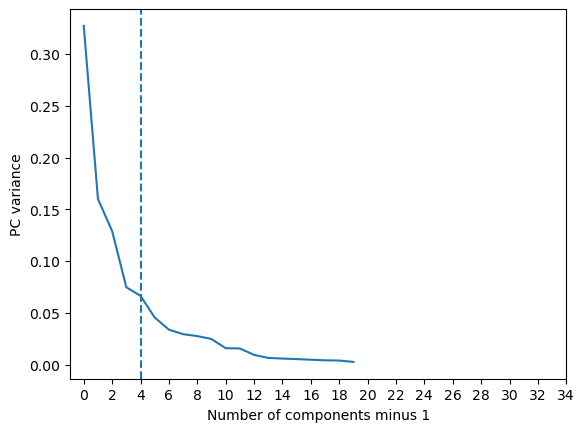

In [99]:
# do a complete PCA and look at the scree and cumulative variance plots
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')

(0.0, 1.0)

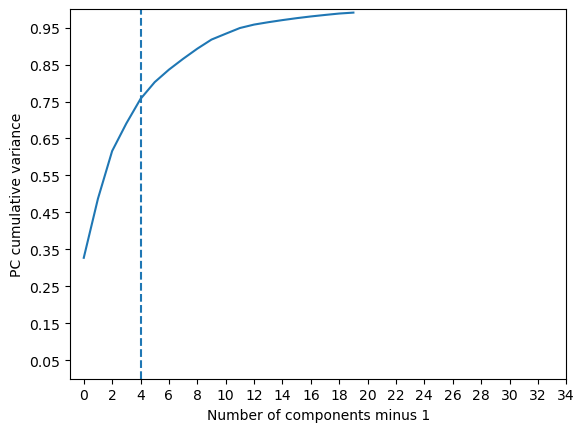

In [100]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')
plt.ylim(0,1)

In [101]:
%%time
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 5, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

CPU times: total: 953 ms
Wall time: 1.24 s


5

In [102]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.32716567 0.4871329  0.61609467 0.6907393  0.75707643]


In [103]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1044493, 5)

In [104]:
data_pca.head(5)

,PC1,PC2,PC3,PC4,PC5
0,-0.307794,-0.264411,0.032923,0.186215,0.165294
1,-0.204484,-0.415906,0.138178,0.274062,0.221104
2,0.006599,-0.716854,0.337726,0.475961,0.300225
3,-0.383299,0.006214,-0.150192,-0.076328,0.008998
4,-0.387083,-0.120647,-0.065984,0.084517,0.102691


In [105]:
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,1.110209e-17,-1.001365e-17,-1.110209e-17,-4.462606e-18,7.401395e-18
std,3.080228e+00,2.153845e+00,1.933880e+00,1.471290e+00,1.387003e+00
min,-5.931319e-01,-5.415794e+02,-3.200695e+02,-1.805555e+02,-1.526916e+02
25%,-4.054777e-01,5.229388e-03,-5.336078e-02,9.146141e-02,3.591142e-02
50%,-3.626133e-01,9.560049e-02,2.274832e-02,1.189986e-01,8.198113e-02
75%,-2.588758e-01,1.442201e-01,7.406458e-02,1.507596e-01,1.080104e-01
max,8.600998e+02,8.837273e+02,5.616293e+02,2.687070e+02,4.531206e+02


In [106]:
# zscale the pcs.
# I do this (make all the retained PCs equally important) if I only keep a small number of PCs.
# Alternatively you can keep maybe up to 6 to 8 or so, and don't do this second z scale
# I prefer to keep a somewhat small number of PCs and then make them all equally important via zscaling.
# This second zscale step makes the later Minkowski distance to be similar to a Mahalanobis distance.
# Many people don't do this second zscaling, but I like to do it.

data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,2.557835e-18,-3.374165e-18,-1.523817e-18,2.525182e-17,1.197284e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.925610e-01,-2.514477e+02,-1.655064e+02,-1.227192e+02,-1.100874e+02
25%,-1.316389e-01,2.427931e-03,-2.759260e-02,6.216409e-02,2.589138e-02
50%,-1.177229e-01,4.438596e-02,1.176305e-02,8.088047e-02,5.910668e-02
75%,-8.404435e-02,6.695936e-02,3.829844e-02,1.024676e-01,7.787324e-02
max,2.792325e+02,4.103021e+02,2.904158e+02,1.826336e+02,3.266905e+02


In [107]:
data_pca_zs.shape

(1044493, 5)

In [108]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4,PC5
0,-0.099926,-0.122762,0.017024,0.126566,0.119173
1,-0.066386,-0.193100,0.071451,0.186273,0.159411
2,0.002142,-0.332825,0.174636,0.323499,0.216456
3,-0.124438,0.002885,-0.077664,-0.051879,0.006487
4,-0.125667,-0.056015,-0.034120,0.057444,0.074038


## Now calculate two unsupervised fraud scores

In [109]:
# Set the powers for the two Minkowski distances. The final results are relatively insensitive to these choices. 
# Good choices are anywhere from 1 to about 4.
p1 = 2
p2 = 2
ntop = 10000

### Calculate score 1

In [110]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0    0.235726
1    0.326970
2    0.541091
3    0.155751
4    0.169928
5    0.166142
6    0.443498
7    0.431434
8    0.431434
9    0.431434
dtype: float64

In [111]:
data_pca_zs.head(10)

,PC1,PC2,PC3,PC4,PC5
0,-0.099926,-0.122762,0.017024,0.126566,0.119173
1,-0.066386,-0.193100,0.071451,0.186273,0.159411
2,0.002142,-0.332825,0.174636,0.323499,0.216456
3,-0.124438,0.002885,-0.077664,-0.051879,0.006487
4,-0.125667,-0.056015,-0.034120,0.057444,0.074038
5,-0.127112,-0.050658,-0.038174,0.050626,0.069707
6,-0.025320,-0.273723,0.134037,0.249383,0.202404
7,-0.029576,-0.265562,0.127704,0.243176,0.198230
8,-0.029576,-0.265562,0.127704,0.243176,0.198230
9,-0.029576,-0.265562,0.127704,0.243176,0.198230


In [112]:
score1.max()

554.5737265593395

### Autoencoder for score 2

In [113]:
%%time
# you don't need the autoencoder to be really good, just a little bit trained so it can find the really unusual records
# you can set max_iter to 100 and it takes about a minute, or 500 and it takes about 7 minutes. But even 50 is good enough.
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

CPU times: total: 54 s
Wall time: 1min 1s


C:\Users\josh9\anaconda3\envs\zanis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=50,
             random_state=1)

In [114]:
# calculate score 2 as the error of an autoencoder
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

In [115]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,0.235726,0.161053,9
1,0.326970,0.256177,10
2,0.541091,0.458860,11
3,0.155751,0.127082,12
4,0.169928,0.098935,13
5,0.166142,0.097233,14
6,0.443498,0.372769,15
7,0.431434,0.360844,16
8,0.431434,0.360844,17
9,0.431434,0.360844,18


In [116]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,0.235726,0.161053,9,802126.0,834349.0
1,0.326970,0.256177,10,873580.0,922833.0
2,0.541091,0.458860,11,931238.0,991940.0
3,0.155751,0.127082,12,11535.0,768212.0
4,0.169928,0.098935,13,213743.0,649943.0
5,0.166142,0.097233,14,143889.0,644086.0
6,0.443498,0.372769,15,909755.0,973547.0
7,0.431434,0.360844,16,906771.0,969869.0
8,0.431434,0.360844,17,906770.0,969871.0
9,0.431434,0.360844,18,906769.0,969870.0


In [117]:
# calculate the final score as the average of the two scores
# you could do other possible combinations of these if you want
# You could do different weightings, or a max or min
weight = .5
scores['final'] = (weight*scores['score1 rank'] + (1-weight)*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores_sorted.head(20)

,score1,score2,RECORD,score1 rank,score2 rank,final
934505,554.573727,549.919061,956520,1044493.0,1044493.0,1044493.0
641107,500.910163,497.790621,658933,1044491.0,1044492.0,1044491.5
615339,501.652444,478.085740,632816,1044492.0,1044491.0,1044491.5
1040913,445.984503,439.748116,1067360,1044490.0,1044490.0,1044490.0
1040562,336.064776,333.277453,1067001,1044489.0,1044489.0,1044489.0
568095,286.536171,262.065971,585118,1044488.0,1044488.0,1044488.0
632014,248.291953,221.532623,649717,1044487.0,1044486.0,1044486.5
899977,237.550627,235.252976,920628,1044484.0,1044487.0,1044485.5
897398,245.832663,211.339492,917942,1044486.0,1044485.0,1044485.5
443552,238.978332,197.447600,459429,1044485.0,1044483.0,1044484.0


In [118]:
scores_sorted.tail(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
425220,0.155007,0.016308,440998,10159.0,670.0,5414.5
191085,0.154316,0.012927,201803,9168.0,62.0,4615.0
619643,0.139824,0.019951,637168,3907.5,3527.5,3717.5
619644,0.139824,0.019951,637169,3907.5,3527.5,3717.5
140172,0.097043,0.021366,142409,15.0,6569.0,3292.0
619641,0.139323,0.019205,637166,3781.5,2529.5,3155.5
619642,0.139323,0.019205,637167,3781.5,2529.5,3155.5
619640,0.138838,0.018702,637165,3721.5,2037.5,2879.5
619639,0.138838,0.018702,637164,3721.5,2037.5,2879.5
95810,0.094603,0.016990,97070,8.0,1090.0,549.0


In [119]:
scores.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,4.246604e-01,1.811600e-01,5.368069e+05,5.222470e+05,5.222470e+05,5.222470e+05
std,2.195373e+00,1.621815e+00,3.080025e+05,3.015193e+05,3.015193e+05,2.918357e+05
min,7.537819e-02,4.933619e-03,9.000000e+00,1.000000e+00,1.000000e+00,5.490000e+02
25%,1.722865e-01,4.486038e-02,2.729100e+05,2.611240e+05,2.611270e+05,2.799445e+05
50%,1.822144e-01,6.665085e-02,5.387720e+05,5.222470e+05,5.222470e+05,4.952070e+05
75%,2.258457e-01,1.326929e-01,8.022750e+05,7.833685e+05,7.833685e+05,7.668775e+05
max,5.545737e+02,5.499191e+02,1.070994e+06,1.044493e+06,1.044493e+06,1.044493e+06


In [120]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,4.246604e-01,1.811600e-01,5.368069e+05,5.222470e+05,5.222470e+05,5.222470e+05
std,2.195373e+00,1.621815e+00,3.080025e+05,3.015193e+05,3.015193e+05,2.918357e+05
min,7.537819e-02,4.933619e-03,9.000000e+00,1.000000e+00,1.000000e+00,5.490000e+02
25%,1.722865e-01,4.486038e-02,2.729100e+05,2.611240e+05,2.611270e+05,2.799445e+05
50%,1.822144e-01,6.665085e-02,5.387720e+05,5.222470e+05,5.222470e+05,4.952070e+05
75%,2.258457e-01,1.326929e-01,8.022750e+05,7.833685e+05,7.833685e+05,7.668775e+05
max,5.545737e+02,5.499191e+02,1.070994e+06,1.044493e+06,1.044493e+06,1.044493e+06


In [121]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
956520,554.573727,549.919061,1044493.0,1044493.0,1044493.0
658933,500.910163,497.790621,1044491.0,1044492.0,1044491.5
632816,501.652444,478.085740,1044492.0,1044491.0,1044491.5
1067360,445.984503,439.748116,1044490.0,1044490.0,1044490.0
1067001,336.064776,333.277453,1044489.0,1044489.0,1044489.0
585118,286.536171,262.065971,1044488.0,1044488.0,1044488.0
649717,248.291953,221.532623,1044487.0,1044486.0,1044486.5
920628,237.550627,235.252976,1044484.0,1044487.0,1044485.5
917942,245.832663,211.339492,1044486.0,1044485.0,1044485.5


(0.1, 2073075.8076083844)

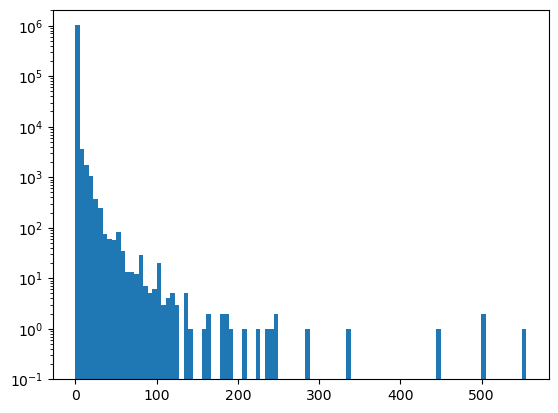

In [122]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [123]:
sc2max = int(score2.max())
sc2max

549

549


(0.1, 2084339.667693663)

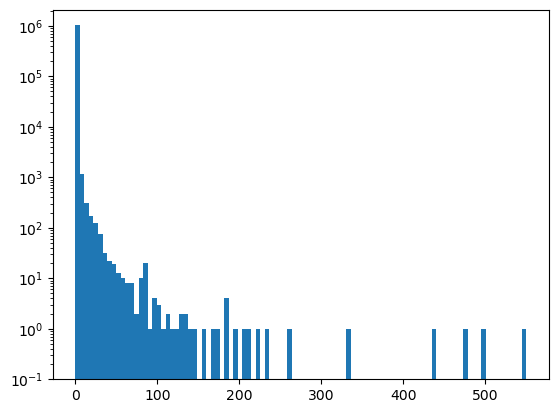

In [124]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

The flatter the next plot, the more similar are the two scores. 
If the two scores are very similar then the rank order hardly changes and the plot is flat.

C:\Users\josh9\anaconda3\envs\zanis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


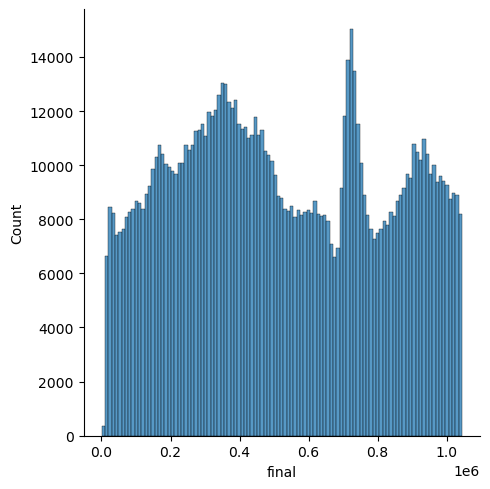

In [125]:
sns.displot(scores['final'])

In [126]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Index([ 956520,  658933,  632816, 1067360, 1067001,  585118,  649717,  920628,
        917942,  459429,
       ...
        985874,  985818,  985873,  985881,  985850,  985888,  985880,  102738,
        861808,  344391],
      dtype='int64', name='RECORD', length=10000)


In [127]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
9,-0.090097,-0.127335,-0.133799,0.110520,-0.062303,-0.123690,0.394405,-0.032892,-0.094573,-0.082212,...,-0.130315,-0.111530,-0.080332,-0.125862,-0.144595,0.049472,-0.086688,-0.125739,0.263333,0.075095
10,-0.077088,-0.130506,-0.160711,0.208937,-0.055878,-0.130003,0.620726,-0.019505,-0.101419,-0.062948,...,-0.130973,-0.116756,-0.037413,-0.122806,-0.146657,0.148234,-0.079064,-0.128060,0.263333,0.075095
11,-0.040796,-0.129753,-0.188728,0.225697,-0.054784,-0.130710,1.252080,0.017839,-0.108528,-0.009209,...,-0.130817,-0.122198,-0.030104,-0.122285,-0.146888,0.423744,-0.057795,-0.130469,0.212785,0.075095
12,-0.107705,-0.097522,0.115824,-0.053838,-0.069858,-0.064452,0.016444,-0.055248,-0.030272,-0.108286,...,-0.124123,-0.063049,-0.152008,-0.129455,-0.125251,-0.115462,-0.099421,-0.103946,0.263334,0.075095
13,-0.102148,-0.120113,-0.072765,0.019357,-0.068255,-0.109320,0.184764,-0.045292,-0.078985,-0.100056,...,-0.128815,-0.099676,-0.120088,-0.128693,-0.139903,-0.042011,-0.093750,-0.120456,0.263334,0.075095


In [128]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
9,802126.0,834349.0,818237.5
10,873580.0,922833.0,898206.5
11,931238.0,991940.0,961589.0
12,11535.0,768212.0,389873.5
13,213743.0,649943.0,431843.0
14,143889.0,644086.0,393987.5
15,909755.0,973547.0,941651.0
16,906771.0,969869.0,938320.0
17,906770.0,969871.0,938320.5


In [129]:
scores.tail(30)

,score1 rank,score2 rank,final
RECORD,,,
1070965,537604.0,366064.0,451834.0
1070966,835532.0,881039.0,858285.5
1070967,825348.0,857376.0,841362.0
1070968,889248.0,953987.0,921617.5
1070969,832094.0,866534.0,849314.0
1070970,732479.0,744684.0,738581.5
1070971,818940.0,848499.0,833719.5
1070972,736222.0,762808.0,749515.0
1070973,760386.0,771364.0,765875.0


In [130]:
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores['final'].fillna(1,inplace=True)
NY_data_with_scores

C:\Users\josh9\AppData\Local\Temp\ipykernel_22844\3385311105.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  NY_data_with_scores['final'].fillna(1,inplace=True)


,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,628010.0,574900.0,601455.0
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,906916.0,971522.0,939219.0
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,863381.0,915207.0,889294.0
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,648912.0,596294.0,622603.0


In [155]:
NY_data_with_scores.sort_values(by=['final'], ascending = False)

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
956519,956520,5006590012,5,659,12,NaN,TROMPETA RIZALINA,A1,1,25,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1044493.0,1044493.0,1044493.0
658932,658933,4029060054,4,2906,54,NaN,WAN CHIU CHEUNG,C0,1,25,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1044491.0,1044492.0,1044491.5
632815,632816,4018420001,4,1842,1,NaN,"864163 REALTY, LLC",D9,2,157,...,1201200.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1044492.0,1044491.0,1044491.5
1067359,1067360,5078530085,5,7853,85,NaN,NaN,B2,1,1,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1044490.0,1044490.0,1044490.0
1067000,1067001,5078120132,5,7812,132,NaN,"DRANOVSKY, VLADIMIR",A3,1,96,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1044489.0,1044489.0,1044489.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188964,188965,2039372935,2,3937,2935,NaN,PARKCHESTER PRESERVAT,R4,2,0,...,8946.0,NaN,2889.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
188965,188966,2039372936,2,3937,2936,NaN,PARKCHESTER PRESERVAT,R4,2,0,...,12386.0,NaN,4002.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
188967,188968,2039372938,2,3937,2938,NaN,PARKCHESTER PRESERVAT,R4,2,0,...,12285.0,NaN,3970.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
188970,188971,2039372941,2,3937,2941,NaN,PARKCHESTER PRESERVAT,R4,2,0,...,12386.0,NaN,4002.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0


In [131]:
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_zs = NY_data_with_scores.join(data_zs, on='RECORD')
NY_data_scored_zs.set_index('RECORD',inplace=True)
NY_data_scored_zs.head(20)

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1000030002,1,3,2,NaN,PARKS AND RECREATION,Q1,4,496,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1000030003,1,3,3,NaN,PARKS AND RECREATION,Q1,4,180,370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1000030010,1,3,10,NaN,DEPT RE-CITY OF NY,Z9,4,362,177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,-0.130315,-0.111530,-0.080332,-0.125862,-0.144595,0.049472,-0.086688,-0.125739,0.263333,0.075095


In [132]:
NY_data_scored_zs_sorted = NY_data_scored_zs.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_top_n = NY_data_scored_zs_sorted.head(ntop)
NY_data_top_n

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
956520,5006590012,5,659,12,NaN,TROMPETA RIZALINA,A1,1,25,91,...,479.439554,527.762215,-0.019741,403.667538,524.119408,-0.061705,380.051108,546.504937,-0.102717,275.530216
632816,4018420001,4,1842,1,NaN,"864163 REALTY, LLC",D9,2,157,95,...,10.914612,3.323431,0.029972,350.220919,136.767354,0.017834,429.329231,195.876653,0.471817,-0.049103
658933,4029060054,4,2906,54,NaN,WAN CHIU CHEUNG,C0,1,25,100,...,401.432336,456.585523,0.069983,379.017833,497.217604,0.052062,315.140615,467.771759,-0.110012,385.936688
1067360,5078530085,5,7853,85,NaN,NaN,B2,1,1,1,...,-0.045062,-0.041229,659.145627,-0.030593,-0.034745,604.232180,-0.023151,-0.026781,-0.110205,55.800526
1067001,5078120132,5,7812,132,NaN,"DRANOVSKY, VLADIMIR",A3,1,96,279,...,358.844372,238.989351,0.020997,375.557618,285.645883,0.019968,325.272752,286.235413,-0.113590,-0.049105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985896,5023631080,5,2363,1080,NaN,VICTOR NASSONKIN,R2,2,0,0,...,-0.072531,-0.119977,0.846865,-0.107743,-0.146840,0.964723,-0.070166,-0.126450,0.257641,-0.047740
985897,5023631081,5,2363,1081,NaN,"MCMILLAN, ROBERT",R2,2,0,0,...,-0.072531,-0.119977,0.846865,-0.107743,-0.146840,0.964723,-0.070166,-0.126450,0.257641,-0.047740
102738,1014191133,1,1419,1133,NaN,"LEWENBERG, SONIA FRIE",R4,2,0,0,...,0.101249,0.522282,0.481235,1.030267,2.959216,-0.112180,0.028487,0.515472,0.155940,0.053217


In [133]:
NY_data_top_n['OWNER'].head(40)

RECORD
956520         TROMPETA RIZALINA
632816        864163 REALTY, LLC
658933           WAN CHIU CHEUNG
1067360                      NaN
1067001      DRANOVSKY, VLADIMIR
585118     NEW YORK CITY ECONOMI
649717                 57-43 LLC
917942      LOGAN PROPERTY, INC.
920628         PLUCHENIK, YAAKOV
459429                       NaN
776306                 TONY CHEN
996722     IMPERIAL COURT HOMEOW
982930     FOREST VIEW HOMEOWNER
980276     WOODMONT WEST HOA INC
562742         109 JAMAICA CORP.
794105      HAVEN BUILDERS, INC.
585120                       NaN
1070428           RICCA, KARISSA
241946       RUFFALO ENTERPRISES
1066922            GALARZA, JOHN
585439     11-01 43RD AVENUE REA
794106      HAVEN BUILDERS, INC.
333412            SPOONER ALSTON
1070515           ALLA LAVRENOVA
1053859                      NaN
1048771     HUGUENOT VILLAGE H O
1045012           LINDA VITALONE
797936           MADAN M LACHMAN
524297             MARTIN OLINER
796933               JALIM, RYAN
104

<Axes: ylabel='OWNER'>

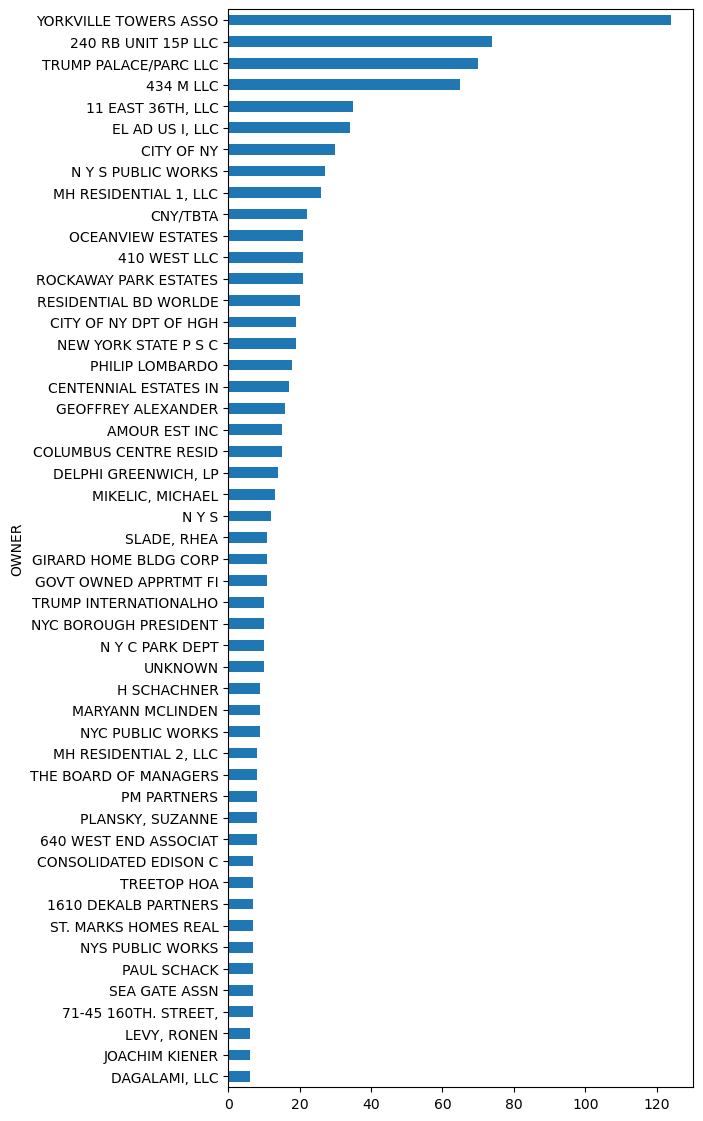

In [134]:
# you can look at this list and add some to the exclusions if you want
plt.figure(figsize=(6,14))
NY_data_top_n['OWNER'].value_counts().head(50).sort_values().plot(kind='barh')

In [135]:
NY_data_top_n.shape

(10000, 63)

In [138]:
NY_data_top_n.to_excel('NY_top_with_zs.xlsx', index=True)
NY_top_lotsize_ne_0 = NY_data_top_n[NY_data_top_n['LTFRONT'] != 0]
NY_top_lotsize_ne_0.to_excel('NY_top_lotsize_ne_0.xlsx', index=True)
NY_top_sizes_ne_0 = NY_top_lotsize_ne_0[NY_top_lotsize_ne_0['BLDDEPTH'] != 0]
NY_top_sizes_ne_0.to_excel('NY_top_sizes_ne_0.xlsx', index=True)

In [145]:
nfields = 34
data_base_vars = NY_data_top_n.iloc[:,nfields:nfields+9]
data_base_vars.head(10)

,r1,r2,r3,r4,r5,r6,r7,r8,r9
RECORD,,,,,,,,,
956520,-0.109964,30.978278,12.583825,-0.090988,23.503351,13.545855,-0.092379,36.486166,26.085835
632816,-0.107375,32.052804,23.826647,0.141617,442.210670,451.187073,0.093826,330.143520,434.539325
658933,-0.100446,25.916962,10.857263,-0.079809,22.063921,12.843380,-0.070188,30.245495,22.311827
1067360,50.705685,-0.131959,-0.219314,82.033701,-0.070772,-0.141152,117.777914,-0.055206,-0.111700
1067001,-0.101230,23.153742,5.578946,-0.085912,21.861860,7.318701,-0.076449,31.219626,13.610036
585118,-0.069525,37.693271,1.191793,-0.073651,519.709085,26.379042,-0.083561,388.002908,25.426491
649717,90.483027,36.487684,16.280534,89.978016,5.822425,6.200257,163.214111,12.923493,15.884808
917942,-0.082279,0.626796,-0.031057,8.219043,111.799983,37.914399,17.758768,217.430558,95.322816
920628,-0.106624,20.736713,7.576116,-0.054491,3.198237,1.526858,-0.092948,18.911201,12.371819


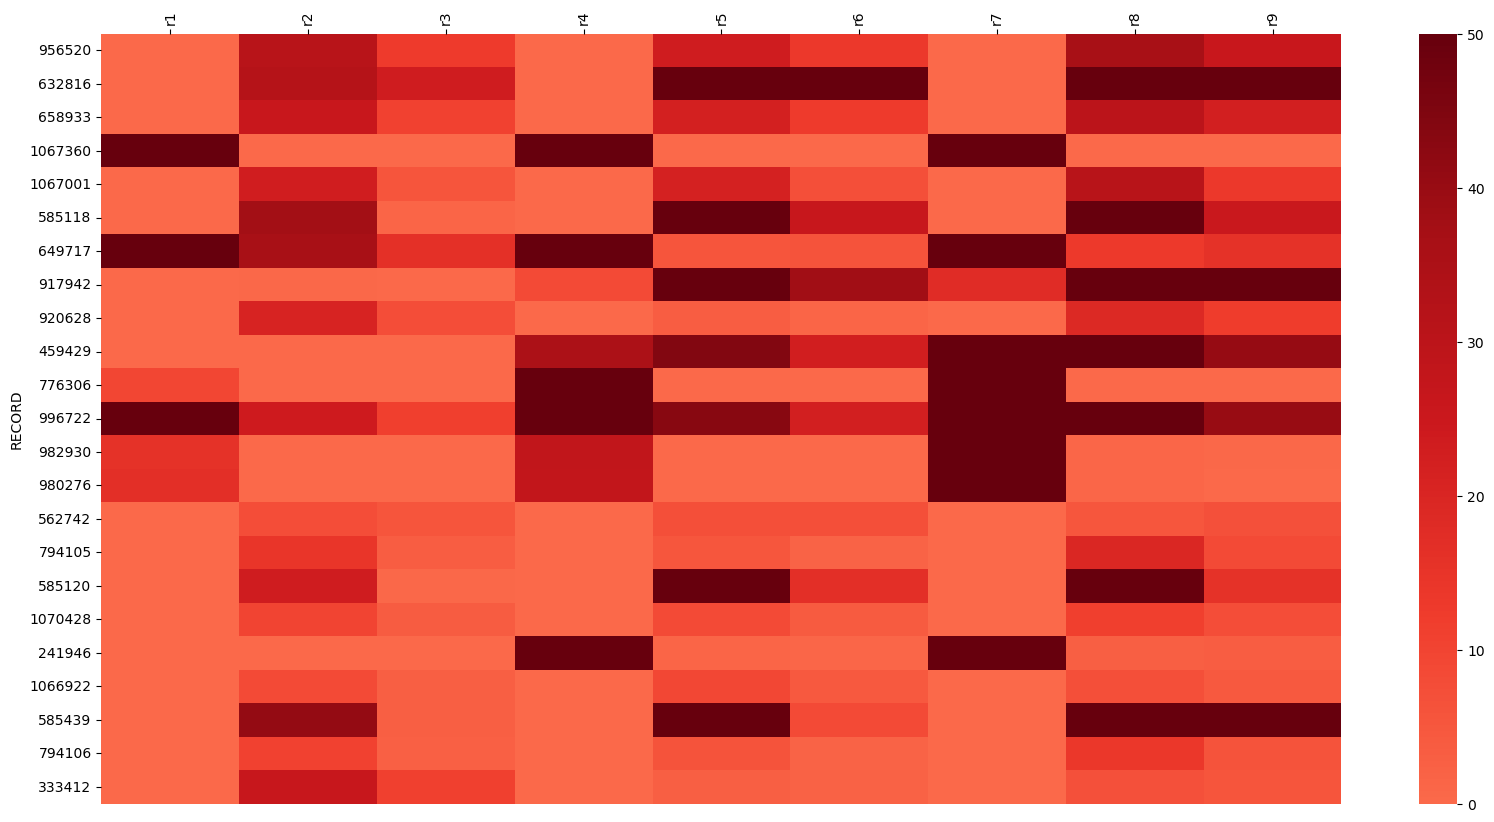

In [140]:
# The heatmaps are good for seeing which variables are driving the high scores
data_heatmap = data_base_vars.abs().head(23)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [141]:
data_all_vars = NY_data_top_n.iloc[:,nfields:]
data_all_vars.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
956520,-0.109964,30.978278,12.583825,-0.090988,23.503351,13.545855,-0.092379,36.486166,26.085835,-0.123972,...,479.439554,527.762215,-0.019741,403.667538,524.119408,-0.061705,380.051108,546.504937,-0.102717,275.530216
632816,-0.107375,32.052804,23.826647,0.141617,442.210670,451.187073,0.093826,330.143520,434.539325,-0.117944,...,10.914612,3.323431,0.029972,350.220919,136.767354,0.017834,429.329231,195.876653,0.471817,-0.049103
658933,-0.100446,25.916962,10.857263,-0.079809,22.063921,12.843380,-0.070188,30.245495,22.311827,-0.113571,...,401.432336,456.585523,0.069983,379.017833,497.217604,0.052062,315.140615,467.771759,-0.110012,385.936688
1067360,50.705685,-0.131959,-0.219314,82.033701,-0.070772,-0.141152,117.777914,-0.055206,-0.111700,60.442293,...,-0.045062,-0.041229,659.145627,-0.030593,-0.034745,604.232180,-0.023151,-0.026781,-0.110205,55.800526
1067001,-0.101230,23.153742,5.578946,-0.085912,21.861860,7.318701,-0.076449,31.219626,13.610036,-0.103927,...,358.844372,238.989351,0.020997,375.557618,285.645883,0.019968,325.272752,286.235413,-0.113590,-0.049105


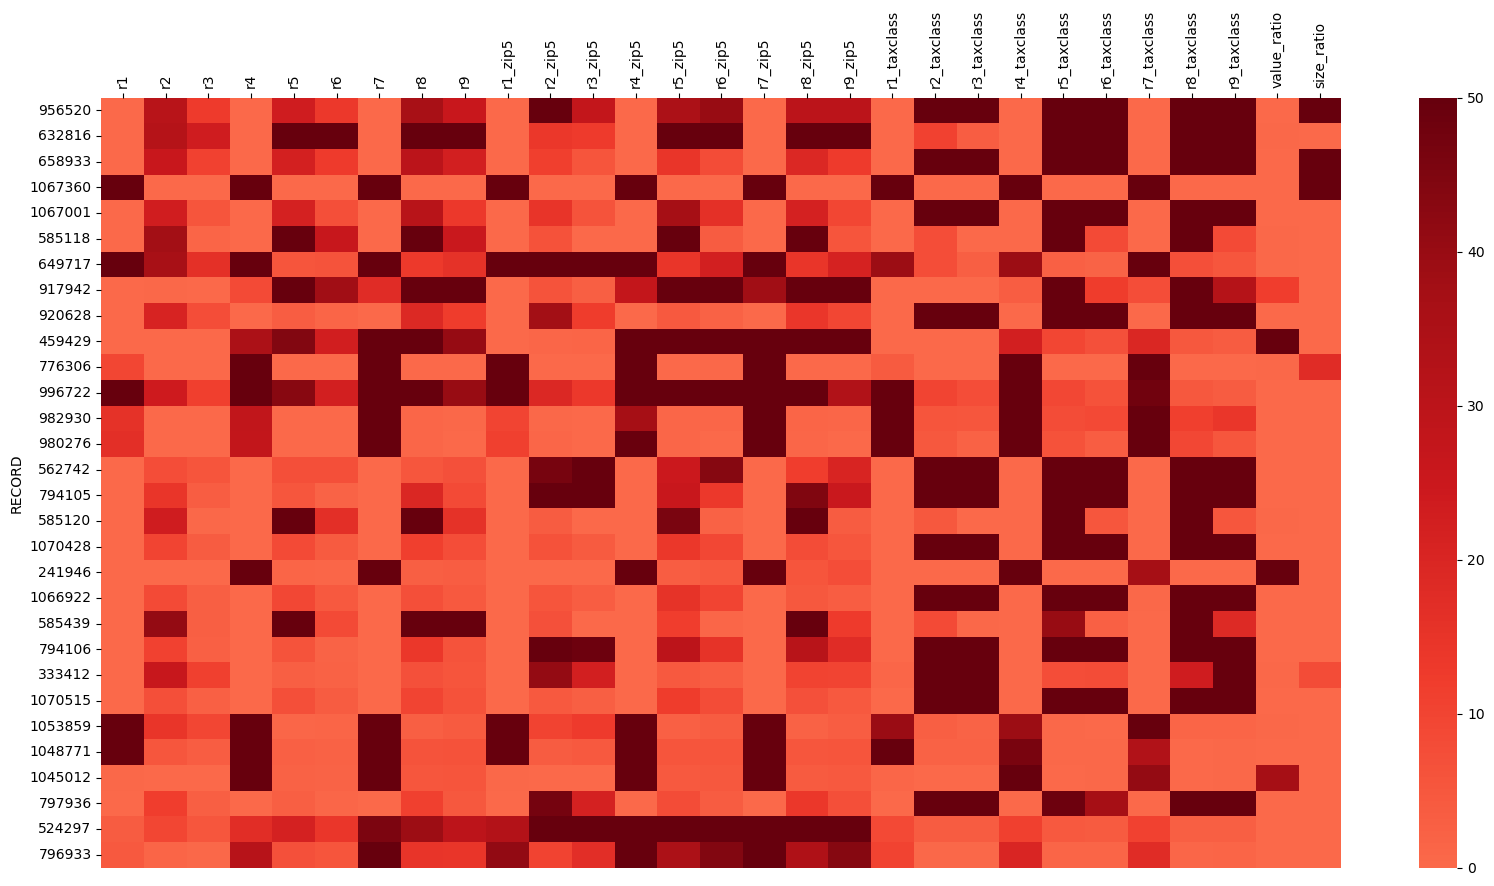

In [142]:
data_heatmap = data_all_vars.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [143]:
top_records_df = pd.DataFrame(top_records)

In [140]:
# Use this cell if you want to write out the top n record numbers
top_records_df.to_csv('top_n_record_numbers_baseline.csv', index=False)

In [141]:
# # Use this cell if you want to compare to a previous top n record numbers.
# # You can run a baseline model, see which records score the highest, then change some of the algorithm parameters
# # to see what % of these top scoring records change. The top records are insensitive to changes in the 
# # powers for the Minkowski distance measures for the two scores

# top_records_previous = pd.read_csv('top_n_record_numbers_baseline.csv')
# print(top_records_df.head())
# print(top_records_previous.head())
# num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
# percent_common = 100*num_common/ntop
# percent_common

In [142]:
print('Duration: ', datetime.now() - start_time)

Duration:  0:00:53.425277


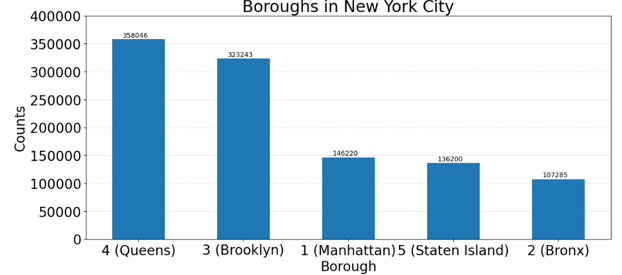

In [224]:
NY_data_with_scores.sort_values(by=['final'], ascending = False).head(4)[['RECORD','TAXCLASS', 'AVTOT', 'AVLAND','BLDFRONT', 'BLDDEPTH', 'STORIES', 'LTFRONT', 'LTDEPTH', 'STADDR']]

,RECORD,TAXCLASS,AVTOT,AVLAND,BLDFRONT,BLDDEPTH,STORIES,LTFRONT,LTDEPTH,STADDR
956519,956520,1,20892.0,15600.0,1812,5020,3.0,25,91,12 ONEIDA AVENUE
658932,658933,1,46560.0,26940.0,2500,5600,3.0,25,100,54-76 83 STREET
632815,632816,2,1318500.0,1318500.0,1,1,1.0,157,95,86-55 BROADWAY
1067359,1067360,1,50160.0,28800.0,36,45,2.0,1,1,20 EMILY COURT


In [220]:
NY_data_scored_zs_sorted.sort_values(by=['final'], ascending = False).head(4)[[
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1_taxclass', 'r2_taxclass',
       'r3_taxclass', 'r4_taxclass', 'r5_taxclass', 'r6_taxclass',
       'r7_taxclass', 'r8_taxclass', 'r9_taxclass', 'ZIP']]

,r1_zip5,r2_zip5,r3_zip5,r4_zip5,r5_zip5,r6_zip5,r7_zip5,r8_zip5,r9_zip5,r1_taxclass,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,ZIP
RECORD,,,,,,,,,,,,,,,,,,,
956520,-0.123972,50.206224,27.406552,-0.131251,35.143800,39.992078,-0.124417,30.279223,30.354275,-0.094419,479.439554,527.762215,-0.019741,403.667538,524.119408,-0.061705,380.051108,546.504937,10301.0
658933,-0.113571,11.347752,5.717759,-0.108132,14.508501,8.092321,-0.080000,19.521388,12.795984,0.027531,401.432336,456.585523,0.069983,379.017833,497.217604,0.052062,315.140615,467.771759,11373.0
632816,-0.117944,14.046447,12.540137,0.127322,291.670312,284.628968,0.113842,213.452020,249.529496,-0.206556,10.914612,3.323431,0.029972,350.220919,136.767354,0.017834,429.329231,195.876653,11373.0
1067360,60.442293,-0.108000,-0.107760,150.298770,-0.087159,-0.094531,96.499896,-0.072312,-0.080712,651.030004,-0.045062,-0.041229,659.145627,-0.030593,-0.034745,604.232180,-0.023151,-0.026781,10307.0
